##  Arquitectura

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision import transforms, datasets


class OurCIFAR10Net(nn.Module):
  def __init__(self):
    '''
    Constructor de la clase
    '''
    super().__init__()

    # Conv1 32 x 32 x 3
    self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
    self.batch_norm_conv1 = nn.BatchNorm2d(num_features=8)
    # Salida de 32 x 32 x 8
    # Max Pooling 2x2, entonces queda 16 x 16 x 8
    # Conv2 16 x 16 x 8
    self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
    self.batch_norm_conv2 = nn.BatchNorm2d(num_features=16)
    # Salida de 16 x 16 x 16
    # Max Pooling 2x2, entonces queda 8 x 8 x 16

    # Fully Connected 1 8 x 8 x 16
    self.fc1 = nn.Linear(8 * 8 * 16, 32)
    self.batch_norm_fc1 = nn.BatchNorm1d(num_features=32)
    # Salida de 1 x 1 x 32
    # Fully Connected 2 1 x 1 x 32
    self.fc2 = nn.Linear(32, 10)
    self.final_activation = nn.Softmax(dim=1)


  def forward(self, x):
    '''
    Método que implementa el forward pass
    '''

    # aplicamos la convolución, sobre ella la función de activación, y después
    # el maxpooling con un kernel_size de 2x2
    out = F.max_pool2d(torch.relu(self.batch_norm_conv1(self.conv1(x))), 2)
    # a esa salida la pasamos por la segunda convolución, otra función de activación,
    # y nuevamente el maxpooling con kernel de 2x2
    out = F.max_pool2d(torch.relu(self.batch_norm_conv2(self.conv2(out))), 2)
    # ahora convertimos el activamos map en un vector
    out = out.view(-1, 8 * 8 * 16)
    # que pasamos por la primera capa fully connected y por la función de activación
    out = torch.relu(self.batch_norm_fc1(self.fc1(out)))
    # y después por la última capa
    out = self.fc2(out)
    return out


  def predict(self, inputs):
    '''
    Método que usaremos de aquí en más cuando queremos predecir resultados
    '''
    # devolvemos el resultado de llamar al modelo y aplicarle la función de activación
    return self.final_activation(self.__call__(inputs))

## Training loop

Contenido del archivo de configuración: {'name-dataset': 'CIFAR', 'name-experiment': 'CIFAR-con-da', 'epochs': 60, 'continue': True, 'visdom': {'url': '192.168.7.192', 'port': 8097}, 'optimizer': 'Adam', 'learning-rate': 0.01, 'path-images': 'no_aplica', 'path-models': '/home/ltelesco/Documents/tpvision/vision-computacional', 'path-class': 'no_aplica', 'path-partition': 'no_aplica'}
Files already downloaded and verified


Setting up a new session...


Visdom en:
url:  192.168.7.192 port:  8097
Files already downloaded and verified
El dispositivo es:  cuda
El numero de epocas es:  60
ep:  0 epoch 60
ep:  1 epoch 60
ep:  2 epoch 60
ep:  3 epoch 60
ep:  4 epoch 60
ep:  5 epoch 60
ep:  6 epoch 60
ep:  7 epoch 60
ep:  8 epoch 60
ep:  9 epoch 60
ep:  10 epoch 60
ep:  11 epoch 60
ep:  12 epoch 60
ep:  13 epoch 60
ep:  14 epoch 60
ep:  15 epoch 60
ep:  16 epoch 60
ep:  17 epoch 60
ep:  18 epoch 60
ep:  19 epoch 60
ep:  20 epoch 60
ep:  21 epoch 60
ep:  22 epoch 60
ep:  23 epoch 60
ep:  24 epoch 60
ep:  25 epoch 60
ep:  26 epoch 60
ep:  27 epoch 60
ep:  28 epoch 60
ep:  29 epoch 60
ep:  30 epoch 60
ep:  31 epoch 60
ep:  32 epoch 60
ep:  33 epoch 60
ep:  34 epoch 60
ep:  35 epoch 60
ep:  36 epoch 60
ep:  37 epoch 60
ep:  38 epoch 60
ep:  39 epoch 60
ep:  40 epoch 60
ep:  41 epoch 60
ep:  42 epoch 60
ep:  43 epoch 60
ep:  44 epoch 60
ep:  45 epoch 60
ep:  46 epoch 60
ep:  47 epoch 60
ep:  48 epoch 60
ep:  49 epoch 60
ep:  50 epoch 60
ep:  51 e

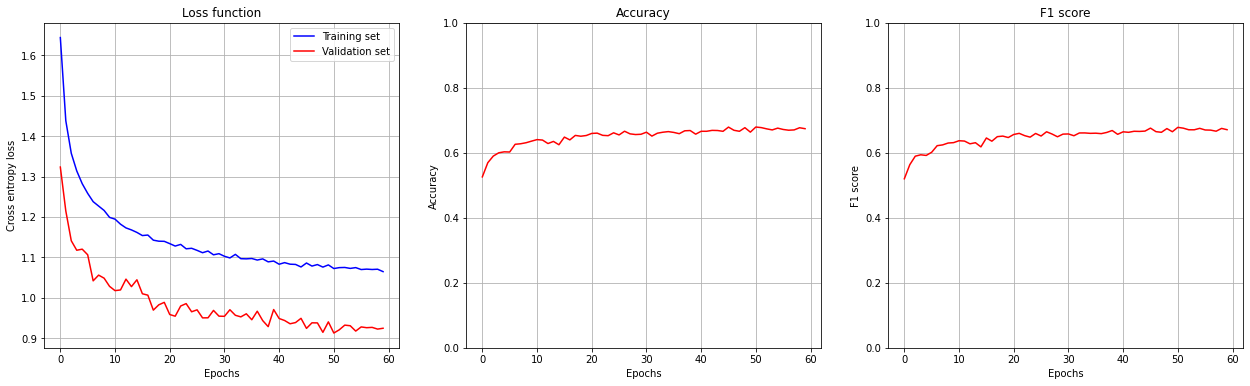

In [12]:
import pickle
import os
import glob
import shutil
import yaml

import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yaml

from os import path
from torch.utils.data import DataLoader
from configparser import ConfigParser
from sklearn.metrics import f1_score, recall_score, precision_score, auc, precision_recall_curve
from teleVersionRandAugment import TeleVersionRandAugment

from util import string_to_list, VisdomLinePlotter

USE_GPU = True
PRODUCTION = 'production'
global plotter


# Path del archivo de configuración YAML
file_config_path = "data_13/params.yaml"

# Abrir y leer el archivo de configuración
try:
    with open(file_config_path, 'r') as config_file:
        dict = yaml.safe_load(config_file)
        print("Contenido del archivo de configuración:", dict)
except FileNotFoundError:
    print(f"Error: El archivo '{file_config_path}' no existe.")
except yaml.YAMLError as e:
    print(f"Error: No se pudo procesar el archivo YAML. Detalles: {e}")

keys = list(dict.keys())

learning_rate = dict['learning-rate']
optimizer_file = dict['optimizer']
path_class = dict['path-class']
path_models = dict['path-models']
path_images = dict['path-images']
path_partition = dict['path-partition']
epochs = dict['epochs']
continued = dict['continue']
visdom_url = dict['visdom']['url']
visdom_port = dict['visdom']['port']
name_experiment = dict['name-experiment']
### Optionals ###
nvalue = 0
mvalue = 0
lamb = 0
dropOutProb = 0
weight= None
if 'nvalue' in keys:
  nvalue = dict['nvalue']
if 'mvalue' in keys:
  mvalue = dict['mvalue']
if 'lamb' in keys:
  lamb = dict['lamb']
if 'drop-out-prob' in keys:
  dropOutProb = dict['drop-out-prob']
if 'weight-class-0' in keys:
  weight = dict['weight-class-0']

###########

## F1 mejor modelo
best_model_f1 = -1
best_model_epoch = -1

# data augmentation
filters ={
            # op_name: (magnitudes, signed)
            "Identity": (torch.tensor(0.0), False),
            "HorizontalFlip": (torch.tensor(0.0), False),
            "VerticalFlip": (torch.tensor(0.0), False),
            "Rotate": (torch.linspace(0.0, 1200, 31), True),

            "Saturation": (torch.linspace(0.0, 1.2, 31), True),
            "Color": (torch.linspace(0.0, 0.3, 31), False),
            "Brightness": (torch.linspace(0.0, 0.9, 31), True),
            "Contrast": (torch.linspace(0.0, 0.7, 31), True),
}

# si n o m son cero, entonces no utilizo regularizacion
if nvalue!=0 or mvalue!=0:
  additionalsTransforms = TeleVersionRandAugment(nvalue, mvalue,filters=filters)
  list_of_training_transformations = transforms.Compose([
        additionalsTransforms,
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
  training_set = datasets.CIFAR10('data_13/', train=True, download=True, transform=list_of_training_transformations)
else:
  list_of_training_transformations = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])  
  training_set = datasets.CIFAR10('data_13/', train=True, download=True, transform=list_of_training_transformations)

folder_model=name_experiment

# Plots
env_name = 'Vision_Training Loop_' + folder_model
plotter = VisdomLinePlotter(env_name=env_name,server=visdom_url,port=visdom_port) 

test_transformations = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])  

validation_set = datasets.CIFAR10('data_13/', train=False, download=True, transform=test_transformations)

# nuevo data loader
training_loader = DataLoader(training_set, batch_size=64, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_set, batch_size=1, shuffle=False, num_workers=0)

#crea carpeta en caso de no existir
os.makedirs(path.join(path_models, folder_model, PRODUCTION), exist_ok=True)
destination = path.join(path_models,folder_model,"info.yaml")
shutil.copyfile('data_13/params.yaml', destination)

####################################################################

# elegimos si usamos cuda o cpu
if USE_GPU:
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print('El dispositivo es: ', device)


resNet_model = OurCIFAR10Net()

n_epochs = epochs
epoch = 0

print('El numero de epocas es: ', n_epochs)

### Inicializo Arreglos ###
per_epoch_training_loss_values = np.zeros(n_epochs)
per_epoch_validation_loss_values = np.zeros(n_epochs)
per_epoch_validation_accuracy_values = np.zeros(n_epochs)
per_epoch_validation_f1_values = np.zeros(n_epochs)
per_epoch_validation_recall_values = np.zeros(n_epochs)
per_epoch_validation_precision_values = np.zeros(n_epochs)

if continued:
  try:  
    with open(path.join(path_models, folder_model, 'metrics.pkl'), 'rb') as handle:
      params = pickle.load(handle)
    per_epoch_training_loss_values = params['training_loss']
    per_epoch_validation_loss_values = params['validation_loss']
    per_epoch_validation_accuracy_values = params['accuracy']
    per_epoch_validation_f1_values = params['f1score']
    per_epoch_validation_recall_values = params['recall']
    per_epoch_validation_precision_values = params['precision']
    best_model_f1 = params['best_model_f1']
    best_model_epoch = params['best_model_epoch']
    l = per_epoch_training_loss_values.tolist()
    epoch = l.index(0.0) if 0.0 in l else len(l)

    for ep in range(epoch):
      print("ep: ",ep,"epoch",epoch)
      ###### Cargo Plot ######
      plotter.plot('loss', 'train', 'Class Loss', ep, per_epoch_training_loss_values[ep])
      plotter.plot('loss', 'val', 'Class Loss', ep, per_epoch_validation_loss_values[ep])
      plotter.plot('acc', 'val', 'Class Accuracy', ep, per_epoch_validation_accuracy_values[ep])
      plotter.plot('F1', 'val', 'Class F1 Score', ep, per_epoch_validation_f1_values[ep])
      plotter.plot('recall', 'val', 'Class Recall', ep, per_epoch_validation_recall_values[ep])
      plotter.plot('precision', 'val', 'Class Precision', ep, per_epoch_validation_precision_values[ep])
      ########################

    toAdd = n_epochs - len(l)
    if toAdd>0:
      per_epoch_training_loss_values = np.append(per_epoch_training_loss_values, np.zeros(toAdd))
      per_epoch_validation_loss_values = np.append(per_epoch_validation_loss_values, np.zeros(toAdd))
      per_epoch_validation_accuracy_values = np.append(per_epoch_validation_accuracy_values, np.zeros(toAdd))
      per_epoch_validation_f1_values = np.append(per_epoch_validation_f1_values, np.zeros(toAdd))
      per_epoch_validation_recall_values = np.append(per_epoch_validation_recall_values, np.zeros(toAdd))
      per_epoch_validation_precision_values = np.append(per_epoch_validation_precision_values, np.zeros(toAdd))
    resNet_model.load_state_dict(torch.load(path.join(path_models, folder_model, 'epoch' + str(epoch) + '-latest-ResNet18.pt')))
  except FileNotFoundError as e:
    print("Error al levantar el modelo. Comenzará desde época 1.")

# creamos la loss function
loss_fn = nn.CrossEntropyLoss()

# movemos a dispositivo elegido
resNet_model = resNet_model.to(device)
loss_fn = loss_fn.to(device)

# Elijo optimizador de parametros. Pasamos los parámetros de nuestro modelo y la learning rate que queremos usar
# momentum ayuda a acelerar las pendeintes en la direccion correcta
if optimizer_file == 'SGD':
  optimizer = optim.SGD(resNet_model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=lamb)
elif optimizer_file == 'Adam':
  optimizer = optim.Adam(resNet_model.parameters(), lr=learning_rate)

print('Learnin Rate', learning_rate)
print('Optimizer', optimizer)
print('Mejor epoca hasta el momento ', best_model_epoch + 1)

# -----------------
# TRAINING LOOP
# -----------------

# iteramos por epocas

while epoch < n_epochs :
  print('Entrenando epoca ',epoch + 1 ,'...')
  # ENTRENAMIENTO
  # modelo en modo entrenamiento
  resNet_model.train()

  # inicializamos una lista para ir guardando los valores de loss por batch
  training_loss_values = np.zeros(len(training_loader))
  
  # iteramos por cada batch
  i=0
  for imgs, labels in training_loader:   
    # pasamos imágenes y labels al dispositivo donde estemos corriendo
    imgs = imgs.to(device)
    labels = labels.view(-1).to(device)
    # obtenemos la respuesta del modelo
    outputs = resNet_model(imgs)
    # calculamos la loss
    loss = loss_fn(outputs, labels)
    
    # mandamos a 0 los gradientes
    optimizer.zero_grad()
    # hacemos un backward pass
    loss.backward()
    # y un paso del optimizador para actualizar los parámetros
    optimizer.step() 
    # registramos el valor de la loss
    training_loss_values[i]=float(loss.cpu())
    i+=1

  # VALIDACIÓN
  # tenemos que poner el modelo en modo evaluación
  resNet_model.eval()

  # inicializamos una lista para guardar los valores de loss por batch en los 
  # datos de validación
  validation_loss_values = np.zeros(len(validation_loader))
  # y dos variables para medir la cantidad de muestras totales y la cantidad de
  # aciertos
  total = 0
  correct = 0

  # no vamos a calcular gradientes
  with torch.no_grad():
      # iteramos por cada batch
      i=0
      y_predict = []
      y_predict_prob = []
      y_true = []
      for imgs, labels in validation_loader:
        # pasamos imágenes y labels al dispositivo donde estemos corriendo
        imgs = imgs.to(device)
        labels = labels.view(-1).to(device)
        # obtenemos la respuesta del modelo
        outputs = resNet_model(imgs)
        # calculamos la loss
        loss = loss_fn(outputs, labels)
        # registramos el valor de la loss
        validation_loss_values[i]=float(loss.cpu())
        i+=1
        # le aplicamos la activation function a las salidas para obtener scores
        probs = resNet_model.final_activation(outputs)
        
        # obtenemos la predicción de la clase
        _, predicted = torch.max(probs.cpu(), dim=1)

        #print("en prob: ", probs[0][0].item(), "en prediction: ", predicted.item())
        y_predict_prob.append(probs[0][0].item())

        labels = labels.cpu()
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        y_predict.append(predicted.item())
        y_true.append(labels.item())     

  # TERMINÓ LA ÉPOCA

  ## actualizamos las estadísticas ##
  
  
  #print("true y predict", lr_precision, lr_recall)

  per_epoch_training_loss_values[epoch] = np.mean(training_loss_values)
  per_epoch_validation_loss_values[epoch] = np.mean(validation_loss_values)
  per_epoch_validation_accuracy_values[epoch] = correct / total
  per_epoch_validation_f1_values[epoch] = f1_score(y_true, y_predict, average='macro')
  per_epoch_validation_recall_values[epoch] = recall_score(y_true, y_predict, average='macro')
  per_epoch_validation_precision_values[epoch] = precision_score(y_true, y_predict, average='macro')

  ###### Cargo Plot ######
  plotter.plot('loss', 'train', 'Class Loss', epoch, per_epoch_training_loss_values[epoch])
  plotter.plot('loss', 'val', 'Class Loss', epoch, per_epoch_validation_loss_values[epoch])
  plotter.plot('acc', 'val', 'Class Accuracy', epoch, per_epoch_validation_accuracy_values[epoch])
  plotter.plot('F1', 'val', 'Class F1 Score', epoch, per_epoch_validation_f1_values[epoch])
  plotter.plot('recall', 'val', 'Class Recall', epoch, per_epoch_validation_recall_values[epoch])
  plotter.plot('precision', 'val', 'Class Precision', epoch, per_epoch_validation_precision_values[epoch])
  ########################

  if (epoch % 1) == 0:
    print('Epoch: {}'.format(epoch+1))
    print('- Training loss: {:.4f}'.format(per_epoch_training_loss_values[epoch]))
    print('- Validation loss: {:.4f}'.format(per_epoch_validation_loss_values[epoch]))
    print('- Validation accuracy: {:.4f}'.format(per_epoch_validation_accuracy_values[epoch]))
    print('- Validation F1 score: {:.4f}'.format(per_epoch_validation_f1_values[epoch]))
  
 ### Guardo modelo ###
  # Acá puede haber un problema cuando elimino el modelo y guardo el ultimo, esto no contempla un corte de luz en el medio por ejemplo
  old_model_files = glob.glob(path.join(path_models, folder_model, '*latest-ResNet18.pt'))

  for old_model in old_model_files:
      try:
          os.remove(old_model)
      except OSError as e:
          print(f"Error:{ e.strerror}")

  # guardo ultimo
  torch.save(resNet_model.state_dict(), path.join(path_models, folder_model, 'epoch' + str(epoch + 1) + '-latest-ResNet18.pt'))
  
  # mejor
  if epoch == 0:
    torch.save(resNet_model.state_dict(), path.join(path_models, folder_model, 'epoch1-best-ResNet18.pt'))
    best_model_f1 = per_epoch_validation_f1_values[epoch]
    best_model_epoch = epoch
  elif per_epoch_validation_f1_values[epoch] > best_model_f1:
 
    old_model_files = glob.glob(path.join(path_models, folder_model, '*best-ResNet18.pt'))
    for old_model in old_model_files:
        try:
            os.remove(old_model)
        except OSError as e:
            print(f"Error:{ e.strerror}")
    
    torch.save(resNet_model.state_dict(), path.join(path_models, folder_model, 'epoch' + str(epoch + 1) + '-best-ResNet18.pt'))
    best_model_f1 = per_epoch_validation_f1_values[epoch]
    best_model_epoch = epoch
  print("Mejor epoca: ", best_model_epoch + 1)
  epoch+=1 

### Guardo metricas ###
  params = {}
  params['training_loss'] = per_epoch_training_loss_values
  params['validation_loss'] = per_epoch_validation_loss_values
  params['accuracy'] = per_epoch_validation_accuracy_values
  params['f1score'] = per_epoch_validation_f1_values
  params['best_model_f1'] = best_model_f1
  params['best_model_epoch'] = best_model_epoch  
  params['recall'] = per_epoch_validation_recall_values
  params['precision'] = per_epoch_validation_precision_values

  with open(path.join(path_models, folder_model, 'metrics.pkl'), 'wb') as handle:
    pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Copio mejor modelo como produccion ###

file_src = path.join(path_models, folder_model, 'epoch' + str(best_model_epoch + 1) + '-best-ResNet18.pt')
f_src = open(file_src, 'rb')
file_dest = path.join(path_models, folder_model,PRODUCTION, 'production-model-ResNet18.pt')
f_dest = open(file_dest, 'wb')
shutil.copyfileobj(f_src, f_dest)

# ------------------------------------------------------------------------------
# -------------------------- GRAFICAMOS LOS RESULTADOS -------------------------
# ------------------------------------------------------------------------------

# creamos plots para la loss, F1 y el accuracy
fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 
# graficamos la evolución de la loss de entrenamiento y la de validación
axes[0].plot(per_epoch_training_loss_values, color='blue')
axes[0].plot(per_epoch_validation_loss_values, color='red')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Cross entropy loss')
axes[0].grid(True)
axes[0].legend(['Training set', 'Validation set'])
axes[0].set_title('Loss function')
# graficamos la evolución del accuracy
axes[1].plot(per_epoch_validation_accuracy_values, color='red')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)
axes[1].set_title('Accuracy')
axes[1].set_ylim([0, 1.0])
#graficamos f1 score
axes[2].plot(per_epoch_validation_f1_values, color='red')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('F1 score')
axes[2].grid(True)
axes[2].set_title('F1 score')
axes[2].set_ylim([0, 1.0])
fig.tight_layout(pad=3.0)
plt.savefig(path.join(path_models, folder_model, 'plot-metrics.png'))
plt.show()

## Evaluacion en nuevos datos

In [ ]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import os

from torchvision import transforms


test_transformations = transforms.Compose([
    transforms.ToTensor(),  # Convierte la imagen en un tensor de PyTorch
    transforms.Resize((32, 32)),  # Redimensiona las imágenes a 32x32
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalización a [-1, 1]
])

# Cargar los datos
images = np.load(os.path.join('data_13', 'cifar10.1_v4_data.npy'))
labels = np.load(os.path.join('data_13', 'cifar10.1_v4_labels.npy'))

## URL del modelo a levantar
path_modelo = 'CIFAR-con-da-2/production/production-model.pt'

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Creamos el dataset utilizando el conjunto de transformaciones definido
dataset = CustomDataset(images, labels, transform=test_transformations)

# Paso 3: Crear un DataLoader para el conjunto de datos
validation_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Paso 4: Inicializamos el modelo, la función de pérdida y el dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Carga del modelo (asegúrate de usar el modelo correcto aquí)
resNet_model = OurCIFAR10Net()

state_dict = torch.load(path_modelo)

# Cargar los parámetros en el modelo
resNet_model.load_state_dict(state_dict)

resNet_model.to(device)
resNet_model.eval()


total = 0
correct = 0
y_predict = []
y_true = []
y_predict_prob = []


# Paso 5: Evaluar el modelo
with torch.no_grad():
    i = 0
    for imgs, labels in validation_loader:
        # Pasamos imágenes y etiquetas al dispositivo
        imgs = imgs.to(device)
        labels = labels.long().to(device)
        # Obtenemos la respuesta del modelo
        outputs = resNet_model(imgs)

        i += 1

        # Aplicamos la función de activación para obtener probabilidades
        probs = torch.softmax(outputs, dim=1)

        # Obtenemos la predicción de la clase
        _, predicted = torch.max(probs, 1)

        # Almacenamos las predicciones y las etiquetas reales
        y_predict_prob.append(probs.cpu().numpy())  # Probabilidades de predicción
        y_predict.append(predicted.cpu().numpy())
        y_true.append(labels.cpu().numpy())

        total += labels.size(0)  # Número total de muestras
        correct += (predicted == labels).sum().item()  # Número de aciertos

# Calcular las métricas finales
accuracy = correct / total
f1 = f1_score(np.concatenate(y_true), np.concatenate(y_predict), average='macro')
recall = recall_score(np.concatenate(y_true), np.concatenate(y_predict), average='macro')
precision = precision_score(np.concatenate(y_true), np.concatenate(y_predict), average='macro')

# Mostrar los resultados
print(f'Validation Accuracy: {accuracy * 100:.2f}%')
print(f'Validation F1 Score: {f1:.4f}')
print(f'Validation Recall: {recall:.4f}')
print(f'Validation Precision: {precision:.4f}')



Validation Accuracy: 54.23%
Validation F1 Score: 0.5450
Validation Recall: 0.5464
Validation Precision: 0.5530
